## 案例背景
某企业由于投放的广告渠道比较多，需要对其做广告效果分析以实现有针对性的广告效果测量和优化工作。跟以应用为目的的案例不同的是，由于本案例是一个分析型案例，该过程的输出其实是不固定的，因此需要跟业务运营方具体沟通需求。
以下是在开展研究之前的基本预设条件：
+ 广告渠道的范畴是什么？具体包括哪些渠道？——所有站外标记的广告类渠道（以ad_开头）。
+ 数据集时间选择哪个时间段？——最近90天的数据。
+ 数据集选择哪些维度和指标？——渠道代号、日均UV、平均注册率、平均搜索量、访问深度、平均停留时间、订单转化率、投放总时间、素材类型、广告类型、合作方式、广告尺寸、广告卖点。
+ 专题分析要解决什么问题？——将广告分类并找出其重点特征，为接下来的业务讨论和数据分析提供支持。

## 案例数据
以下是本数据集的13个字段的详细说明：
+ 渠道代号：业务方统一命名规划的唯一渠道标志。
+ 日均UV：每天的平均独立访客，从一个渠道中带来的一个访客即使一天中到达多次都统计为1次。
+ 平均注册率：日均注册的用户数量/平均每天的访问量。
+ 平均搜索量：平均每个访问的搜索次数。
+ 访问深度：总页面浏览量/平均每天的访问量。
+ 平均停留时间：总停留时间/平均每天的访问量。
+ 订单转化率：总订单数量/平均每天的访问量。
+ 投放总时间：每个广告媒介在站外投放的天数。
+ 素材类型：广告素材类型，包括jpg、gif、swf、sp。
+ 广告类型：广告投放类型，包括banner、tips、横幅、通栏、暂停以及不确定（不知道到底是何种形式）。
+ 合作方式：广告合作方式，包括roi、cpc、cpm和cpd。
+ 广告尺寸：每个广告投放的尺寸大小，包括140*40、308*388、450*300、600*90、480*360、960*126、900*120、390*270。
+ 广告卖点：广告素材上主要的卖点诉求信息，包括打折、满减、满赠、秒杀、直降、满返。

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics   # 导入sklearn效果评估模块
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 载入数据，空格为间隔
df = pd.read_csv('https://raw.githubusercontent.com/ffzs/dataset/master/ad_performance.txt', delimiter='\t')

In [3]:
# 数据概观
df.tail(3).T

,886,887,888
渠道代号,A40,A41,A826
日均UV,310.53,1370.38,0.86
平均注册率,0.0002,0.0001,0
平均搜索量,0.0028,0.0016,0
访问深度,1.1546,1.3939,52.6591
平均停留时间,543.8,613.32,1932.61
订单转化率,0.0001,0.0001,0
投放总时间,22,10,19
素材类型,swf,swf,gif
广告类型,通栏,通栏,暂停


In [4]:
# 数据类型
df.dtypes

渠道代号       object
日均UV      float64
平均注册率     float64
平均搜索量     float64
访问深度      float64
平均停留时间    float64
订单转化率     float64
投放总时间     float64
素材类型       object
广告类型       object
合作方式       object
广告尺寸       object
广告卖点       object
dtype: object

In [5]:
# 缺失值情况
df.isna().sum()

渠道代号      0
日均UV      0
平均注册率     0
平均搜索量     0
访问深度      0
平均停留时间    2
订单转化率     0
投放总时间     0
素材类型      0
广告类型      0
合作方式      0
广告尺寸      0
广告卖点      0
dtype: int64

In [6]:
# 原始数据基本描述
df.describe().round(3)

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000,889.000,889.000,889.000,887.000,889.000,889.000
mean,540.847,0.001,0.030,2.167,262.669,0.003,16.053
std,1634.410,0.003,0.106,3.801,224.365,0.012,8.509
min,0.060,0.000,0.000,1.000,1.640,0.000,1.000
25%,6.180,0.000,0.001,1.392,126.020,0.000,9.000
50%,114.180,0.000,0.003,1.793,236.550,0.000,16.000
75%,466.870,0.001,0.012,2.216,357.985,0.002,24.000
max,25294.770,0.039,1.037,98.980,4450.830,0.216,30.000


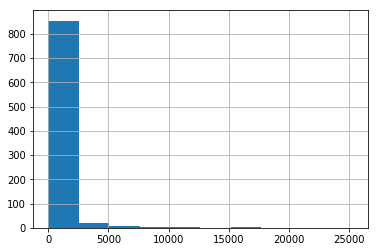

In [10]:
df.iloc[:, 1].hist()

如下的描述性统计结果中，反映了3个信息点：
+ 日均UV的数据标准差很大，说明了不同渠道间的特征差异非常明显。
+ 平均停留时间的有效数据（非空数据）只有887，比其他数据少2条，这也印证了上述缺失值统计结果。
+ 平均注册率、平均搜索量、订单转化率的多个统计量（例如最小值、25%分位数等）都为0，看似数据不太正常。

In [11]:
# 计算特征相关性
df.corr()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
日均UV,1.000000,-0.051159,-0.073483,-0.021726,0.035083,-0.045224,-0.038488
平均注册率,-0.051159,1.000000,0.238122,0.106264,0.220294,0.316553,-0.014101
平均搜索量,-0.073483,0.238122,1.000000,0.063127,0.165074,0.125908,-0.026784
访问深度,-0.021726,0.106264,0.063127,1.000000,0.724685,0.163709,0.057460
平均停留时间,0.035083,0.220294,0.165074,0.724685,1.000000,0.253011,0.047051
订单转化率,-0.045224,0.316553,0.125908,0.163709,0.253011,1.000000,-0.004612
投放总时间,-0.038488,-0.014101,-0.026784,0.057460,0.047051,-0.004612,1.000000


通过相关性结果分析，12个特征中平均停留时间和访问深度的相关系数为0.72，这两个指标具有较高的相关性，但特征也不是非常明显；其他特征之间的相关性关系都不突出。

In [13]:
# 使用平均值替换缺失值
df = df.fillna(df['平均停留时间'].mean())

In [16]:
# 字符串分类转整数分类
conver_cols = ['素材类型', '广告类型', '合作方式', '广告尺寸', '广告卖点']
convert_matrix = df[conver_cols]  # 获得要转换的数组
lines = df.shape[0]  # 获得总记录数
dict_list = []  # 总空列表，用于存放字符串与对应索引组成的字典
unique_list = []  # 总唯一值列表，用于存储每个列的唯一值列表
for col_name in conver_cols:  # 循环读取每个列名
    cols_unqiue_value = df[col_name].unique().tolist()  # 获取列的唯一值列表
    unique_list.append(cols_unqiue_value)  # 将唯一值列表追加到总列表
for line_index in range(lines):  # 读取每行索引
    each_record = convert_matrix.iloc[line_index]  # 获得每行数据，是一个Series
    for each_index, each_data in enumerate(each_record):  # 读取Series每行对应的索引值
        list_value = unique_list[each_index]  # 读取该行索引对应到总唯一值列表列索引下的数据(其实是相当于原来的列做了转置成了行，目的是查找唯一值在列表中的位置)
        each_record[each_index] = list_value.index(each_data)  # 获得每个值对应到总唯一值列表中的索引
    each_dict = dict(zip(conver_cols, each_record))  # 将每个值和对应的索引组合字典
    dict_list.append(each_dict)  # 将字典追加到总列表
model_dvtransform = DictVectorizer(sparse=False, dtype=np.int64)  # 建立转换模型对象
data_dictvec = model_dvtransform.fit_transform(dict_list)  # 应用分类转换训练

In [18]:
# 获取特征转换成矩阵
scale_matrix = df.iloc[:, 1:8]
# 建立MinMaxScaler模型对象
minmax_scaler = MinMaxScaler()
# 标准化数据
data_scaled = minmax_scaler.fit_transform(scale_matrix)

In [19]:
# 矩阵合并成目标数据
X = np.hstack((data_scaled, data_dictvec))

In [22]:
# 用来存储每个k下模型的平均轮廓系数
score_list =[]
# 初始化的平均轮廓系数阈值
silhouette_int = -1
# k取分别取2-9，评估模型情况
for n_clusters in range(2, 10):
    # 建立聚类模型对象
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # 训练聚类模型
    labels = kmeans.fit_predict(X)
    # 获取每个K的平均轮廓系数
    silhouette_tmp = metrics.silhouette_score(X, labels)
    # 如果平均轮廓系数更高，储存模型
    if silhouette_tmp > silhouette_int:
        best_k = n_clusters    # 记录最好K
        best_kmeans = kmeans   # 记录最好模型
        silhouette_int = silhouette_tmp  # 记录最好平均轮廓
        cluster_labels = labels   #记录最好的labels
    # 记录每次的K和轮廓值
    score_list.append([n_clusters, silhouette_tmp])
print ('{:＊^60}'.format('K value and silhouette summary:'))
print (np.array(score_list))  # 打印输出所有K下的详细得分
print ('Best K is:{} with average silhouette of {}'.format(best_k, silhouette_int.round(4)))

＊＊＊＊＊＊＊＊＊＊＊＊＊＊K value and silhouette summary:＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊
[[2.         0.46692821]
 [3.         0.54904646]
 [4.         0.56968547]
 [5.         0.48186604]
 [6.         0.45477667]
 [7.         0.48204261]
 [8.         0.50447223]
 [9.         0.52697493]]
Best K is:4 with average silhouette of 0.5697


对于平均轮廓系数而言，其值域分布式[-1, 1]。因此silhouette_int的初始值可以设置为-1或比-1更小的值。

上述结果显示了不同K下的平均轮廓得分。就经验看，如果平均轮廓得分值小于0，意味着聚类效果不佳；如果值大约0且小于0.5，那么说明聚类效果一般；如果值大于0.5，则说明聚类效果比较好。本案例在K=4时，得分为0.5697，说明效果较好。

In [23]:
# 将最优情况的标签整合到原始数据上
df['clusters'] = cluster_labels

In [101]:
# 每个聚类的样本量
cluster_count = pd.DataFrame(df.clusters.value_counts()).rename(columns={'clusters': 'counts'})
# 获取样本占比
cluster_count['percentage'] = (cluster_count.counts/cluster_count.counts.sum()).round(2)
cluster_count

,counts,percentage
0,411,0.46
1,297,0.33
3,154,0.17
2,27,0.03


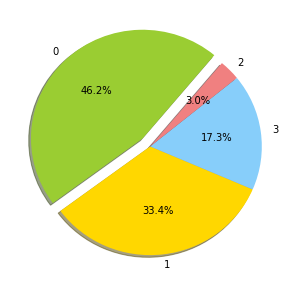

In [102]:
### 可视化 ###
# 设置颜色
colors='yellowgreen','gold','lightskyblue','lightcoral'
# 设置分离
explode=0.1,0,0,0
# 设置画幅
plt.figure(figsize=(5, 5))
# 作图
plt.pie(cluster_count.counts,explode=explode,labels=cluster_count.index,colors=colors,autopct='%1.1f%%',shadow=True,startangle=50)
plt.savefig('x.png')

In [58]:
# 空列表，用于存储最终合并后的所有特征信息
cluster_features = []  
for line in range(best_k):  # 读取每个类索引
    label_data = df[df['clusters'] == line]  # 获得特定类的数据

    part1_data = label_data.iloc[:, 1:8]  # 获得数值型数据特征
    part1_desc = part1_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part1_desc.iloc[1, :]  # 得到数值型特征的均值

    part2_data = label_data.iloc[:, 8:-1]  # 获得字符串型数据特征
    part2_desc = part2_data.describe(include='all')  # 获得字符串型数据特征的描述性统计信息
    merge_data2 = part2_desc.iloc[2, :]  # 获得字符串型数据特征的最频繁值

    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # 将数值型和字符串型典型特征沿行合并
    cluster_features.append(merge_line)  # 将每个类别下的数据特征追加到列表

In [88]:
# 将列表转化为矩阵
cluster_pd = pd.DataFrame(cluster_features) 
# 将信息合并
all_cluster_set = cluster_count.join(cluster_pd).sort_index().T
all_cluster_set

,0,1,2,3
counts,411,297,27,154
percentage,0.46,0.33,0.03,0.17
日均UV,539.117,461.381,973.638,622.838
平均注册率,0.001,0.001,0.001,0.003
平均搜索量,0.023,0.044,0.051,0.02
访问深度,1.863,2.424,3.873,2.183
平均停留时间,203.328,335.252,441.967,249.625
订单转化率,0.002,0.004,0.006,0.003
投放总时间,15.601,16.879,15.37,15.786
素材类型,swf,jpg,swf,jpg


In [93]:
# 获取要显示的数据
num_sets = cluster_pd.iloc[:,:6].astype('float64')

In [94]:
num_sets

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率
0,539.117,0.001,0.023,1.863,203.328,0.002
1,461.381,0.001,0.044,2.424,335.252,0.004
2,973.638,0.001,0.051,3.873,441.967,0.006
3,622.838,0.003,0.020,2.183,249.625,0.003


In [95]:
# 获得标准化后的数据
num_sets_max_min = minmax_scaler.fit_transform(num_sets)  

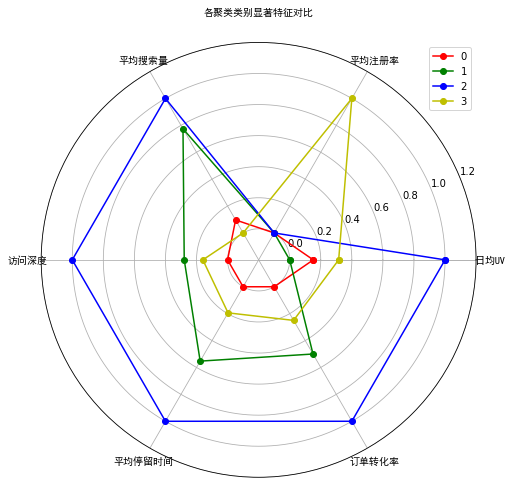

In [105]:
fig = plt.figure(figsize=(8, 8))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index[:-1])  # 设置要展示的数据标签
cor_list = ['r', 'g', 'b', 'y']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
    ax.plot(angles, data, 'o-', c=cor_list[i], label=i)  # 画线
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title("各聚类类别显著特征对比", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置
plt.savefig('xx.png')
plt.show()  # 展示图像

使用`fig.add_subplot(111, polar=True)`为fig对象增加一个子网格，其中参数polar=True用来设置该子网格对象显示极坐标系。
`np.array(merge_data1.index[:-1])`设置要展示的数据标签，标签从merge_data1的索引中获取。
定义不同类别的颜色列表cor_list，分别代表红色、绿色、蓝色、黄色。
通过`np.linspace(0, 2*np.pi, len(labels), endpoint=False)`计算各个区间的角度，由于要在雷达图中显示多个类别，这里需要按照类别将整个“圆”按照类别数平均划分。其中各个参数如下：
+ 0：创建间隔区间的起始。
+ 2*np.pi：创建间隔区间的末尾。
+ len(labels)：间隔长度。
+ endpoint：值设置False代表间隔的最后一个值不是间隔区间的末尾。

最后使用`angles = np.concatenate((angles, [angles[0]]))`建立相同首尾字段以便于闭合。默认情况下，每个类别的多个特征在雷达图中首尾应该是相连的，这样才能形成闭合效果，因此这里将第一个只追加到列表末尾。

## 案例总结
### 初步分析：
聚类1（索引值为0）：各方面的特征都不明显，换句话说就是效果比较平庸，没有明显的优势或短板。但这些“中庸”的广告媒体却构成了整个广告的主体。
聚类2（索引值为1）：这类广告媒体在访问深度、平均停留时间、订单转化率以及平均搜索量等流量质量的特征上的表现较好，除了注册转化率较低外，该类渠道各方面比较均衡。更重要的是该类媒体的数量占据了33%的数量，因此是一类规模较大且综合效果较好的媒体。
聚类3（索引值为2）：这类广告媒体跟聚类2非常类似，并且相对聚类2的典型特征表现更好，但综合其只占3%的媒体数量，属于少量的“精英”类渠道。
聚类4（索引值为3）：这类渠道跟其他几类渠道有个明显的特征区隔，其日均UV和平均注册率非常突出，证明这是一类“引流”+“拉新”的渠道；而其他的流量质量方面的表现却比较差。
### 深入分析：
聚类1的广告渠道各方面表现均比较一般，因此需要业务部门重点考虑其投放的实际价值。
聚类2的广告渠道的短板是日均UV和平均注册率，因此该类媒体无法为企业带来大量的流量以及新用户。这类广告的特质适合用户转化，尤其是有关订单转化的提升。
聚类3的广告渠道跟效果拔群，但是由于实例比较少，不排除是因为个例导致效果扩大，可以合理增加此类渠道投放。
聚类4的广告渠道更佳符合广告本身“广而告之”的基础诉求，因此适合在大规模的广告宣传和引流时使用，尤其对于新用户的注册转化上的效果非常明显，也适合“拉新”使用。

## 案例引申
本案例中通过平均轮廓系数的方法得到的最佳K值不一定在业务上具有明显的解读和应用价值。如果最佳K值的解读无效怎么办？有两种思路：
+ 扩大K值范围，例如将K的范围调整为[2,12]，然后再次运算看更大范围内得到的K值是否更加有效并且能符合业务解读和应用需求。
+ 得到平均轮廓系数“次要好”（而不是最好）的K值，再对其结果做分析。

对于不同类别的典型特征的对比，除了使用雷达图直观地显示外，还可以使用多个柱形图的形式，将每个类别对应特征的值做柱形图统计，这样也是一个非常直观的对比方法。